In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sklearn
print(sklearn.__version__)

1.0.2


In [4]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [5]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [6]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path, snana_ob_type_name
from kndetect.features import extract_features_all_lightcurves, get_feature_names
from kndetect.training import append_y_true_col
from kndetect.predict import filter_no_coeff_events
from kndetect.activelr import run_AL_loops

In [7]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [8]:
use_already_trained_features = True
use_already_trained_models = True
mimic_alerts = False
save_data = True
save_results_plots = True
sub_directory=None

use_AL = True
use_already_trained_AL_features = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"
    
plot_path_prefix=None
if save_results_plots:
    plot_path_prefix = sub_directory

In [9]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [10]:
filter_indices = filter_no_coeff_events(train_features_df)
filtered_train_features_df = train_features_df[filter_indices]

In [11]:
num_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [12]:
print("Total KN events in train set: {}".format(num_kn_train))
print("Total non KN events in test set: {}".format(num_non_kn_train))
print("Total number of events: {}".format(num_kn_train + num_non_kn_train))

Total KN events in train set: 2794
Total non KN events in test set: 16712
Total number of events: 19506


In [13]:
if use_AL:
    if use_already_trained_AL_features:
        data_path=os.path.join(data_dir, sub_directory, "AL", "train.csv")
        filtered_train_features_df = pd.read_csv(data_path)
    else:
        data_base_path=os.path.join(data_dir, sub_directory)
        feature_names = get_feature_names()
        filtered_train_features_df = filtered_train_features_df[['key', 'y_true'] + feature_names]
        filtered_train_features_df.reset_index(inplace=True, drop=True)

        filtered_train_features_df = run_AL_loops(features_df=filtered_train_features_df, save_data=save_data, nloops=1490, data_base_path=data_base_path)

In [14]:
filtered_train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,y_true
0,-0.335488,0.242571,-0.589766,2.968236,297.427826,-2.000000,0.838011,1.220314,5.332776,214.686172,3010564,False
1,0.696377,-0.092045,0.120427,1.710311,480.130025,0.645799,0.214855,-0.048319,1.251631,700.323311,7089843,True
2,0.437178,0.028765,0.247187,7.536351,2403.269043,0.501660,0.010488,0.259629,11.134726,3342.364746,11166239,True
3,0.303729,0.142268,0.120408,1.555476,351.472107,0.535069,0.011940,0.285170,1.670796,382.208618,17130447,True
4,0.314755,0.293027,-0.164813,1.466868,548.375732,0.419139,0.390858,-0.134703,1.061371,664.110107,22239561,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.108882,0.032551,-0.127516,0.956627,264.055084,0.604163,0.052710,0.375646,1.346959,938.613159,48430202,True
1496,0.973911,0.070440,-0.045487,0.851942,318.849976,0.602557,-0.581812,-0.129245,1.449739,232.977966,91383246,False
1497,0.495760,-0.015913,0.408605,2.113550,1015.812866,0.451606,-0.031566,0.377425,1.557003,702.878662,38300004,True
1498,0.693384,0.200878,-0.220467,1.093315,401.471191,0.663443,0.199415,-0.238125,2.338079,1037.764282,71841257,True


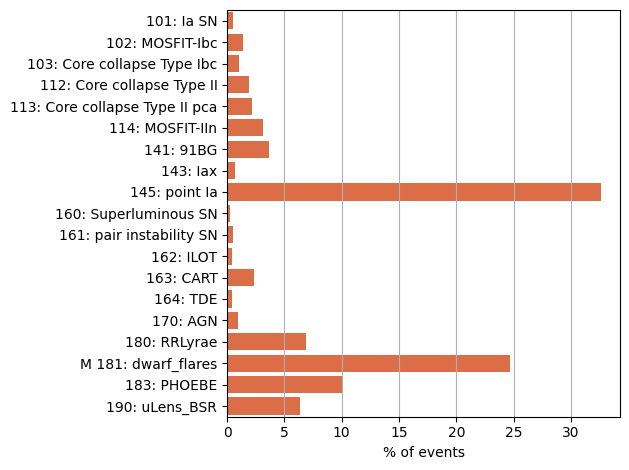

In [15]:
import seaborn as sns

sns.set_style({'axes.grid': True})
al_distribution = {}
for SNTYPE in np.unique(df_header["SNTYPE"].values):
    if SNTYPE in [149, 150, 151]:
        continue
    al_distribution[SNTYPE] = 0

for key in filtered_train_features_df["key"]:
    row = df_header[df_header["SNID"] == key]
    if row["SNTYPE"].values[0] in [149, 150, 151]:
        continue
    al_distribution[row["SNTYPE"].values[0]]+=1
    

al_type_names = []
al_freq = []
for key in al_distribution.keys():
    al_type_names.append(snana_ob_type_name(key))
    al_freq.append(al_distribution[key])
    
al_freq=np.array(al_freq)
al_freq = al_freq/np.sum(al_freq) * 100

#pd.DataFrame(al_distribution)
ax = sns.barplot(y = al_type_names, x = al_freq, orient='h', color='#F5622E')
ax.set_xlabel("% of events")
plt.tight_layout()

if save_results_plots:
    plt.savefig(os.path.join("results", sub_directory, "al_event_distribution"))

In [16]:
df_peng = sns.load_dataset("penguins")
df_peng

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [17]:
num_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==True])
num_non_kn_train_final = len(filtered_train_features_df[filtered_train_features_df["y_true"]==False])

In [18]:
print("Total KN events in train set: {}".format(num_kn_train_final))
print("Total non KN events in test set: {}".format(num_non_kn_train_final))
print("Total number of events: {}".format(num_kn_train_final + num_non_kn_train_final))

Total KN events in train set: 731
Total non KN events in test set: 769
Total number of events: 1500


# Now Train the classifier

In [19]:
from kndetect.training import train_classifier
from kndetect.predict import load_classifier, predict_kn_score

In [20]:
if not use_already_trained_models:
    clf, filtered_train_features_df = train_classifier(filtered_train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")
    probabilities, filtered_indices = predict_kn_score(clf, filtered_train_features_df)
    filtered_train_features_df['y_score'] = probabilities.T[1]
    filtered_train_features_df['y_pred'] = filtered_train_features_df['y_score']>.5

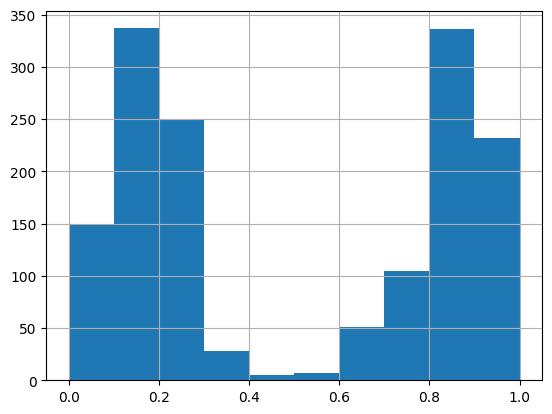

In [21]:
fig = plt.figure()
plt.hist(filtered_train_features_df['y_score']);
plt.savefig("score_distrib")

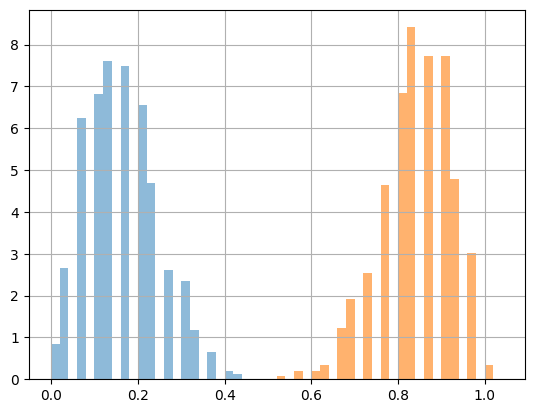

In [22]:
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered_train_features_df[filtered_train_features_df['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("train_scores_distrib")

In [23]:
# Generate Test features and Predict probabilities

In [24]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [25]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [26]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)
test_features_df['y_score'] = probabilities.T[1]
filtered=test_features_df[filtered_indices]

In [27]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_score"]>0.5

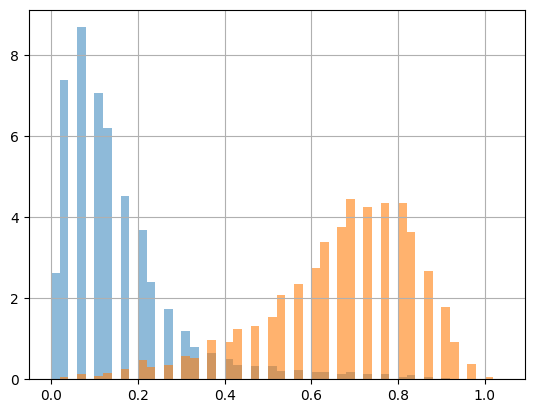

In [28]:
%matplotlib inline
bins = np.arange(0,1.05, .02)
hist = plt.hist(filtered[filtered['y_true']==0]['y_score'], bins=bins, density=True, alpha=0.5)
hist = plt.hist(filtered[filtered['y_true']==1]['y_score'], bins=bins, density=True, alpha=0.6)


plt.savefig("test_scores")

In [29]:
y1 = filtered[filtered['y_true']==0]['y_pred_score']
y2 = filtered[filtered['y_true']==1]['y_pred_score']

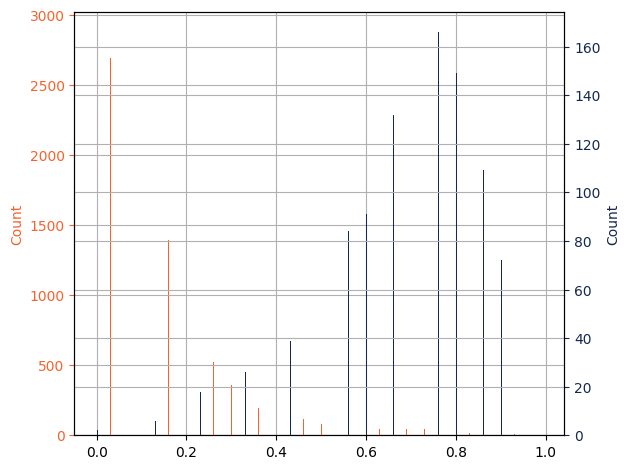

In [30]:
colors=['#F5622E', '#15284F']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([y1, y2])
n, bins, patches = ax1.hist([y1,y2], bins=100)
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * 0.1
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

In [31]:
y_true_train = filtered_train_features_df["y_true"]
y_pred_train = filtered_train_features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 1500
total number of KN: 731
total number of non KN: 769

True Positive : 731
False Positive : 0
True negative : 769
False negative : 0


In [32]:
tp = np.sum(y_true&y_pred)
fp = np.sum(~y_true&y_pred)
tn = np.sum(~y_true&~y_pred)
fn = np.sum(y_true&~y_pred)

In [33]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {}".format(tp))
print("False Positive : {}".format(fp))
print("True negative : {}".format(tn))
print("False negative : {}".format(fn))

test statistics:

total number of events: 18715
total number of KN: 1892
total number of non KN: 16823

True Positive : 1555
False Positive : 550
True negative : 16273
False negative : 337


In [34]:
print("Total num of KN train + test : {}".format(num_kn_train + np.sum(y_true)))
print("Total num of non KN train + test : {}".format(num_non_kn_train + np.sum(~y_true)))
print("Total number of events : {}".format(num_kn_train + np.sum(y_true) + num_non_kn_train + np.sum(~y_true)))

Total num of KN train + test : 4686
Total num of non KN train + test : 33535
Total number of events : 38221


In [35]:
precision = tp * 100 / (tp+fp)
recall = tp*100 / (tp+fn)

print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))

Precision: 73.87%
Recall: 82.19%


In [36]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.86951643 0.02938819]
 [0.01800695 0.08308843]]


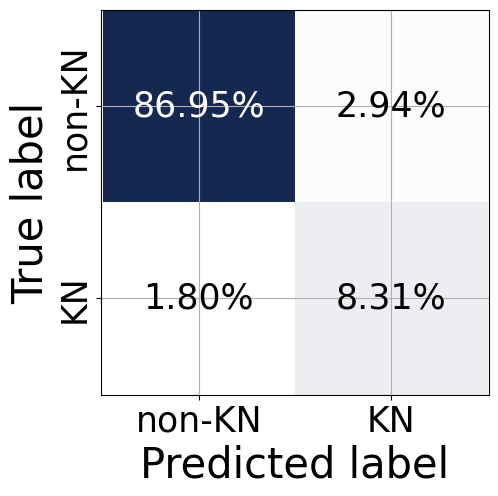

In [37]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred, save_fig_prefix=plot_path_prefix)

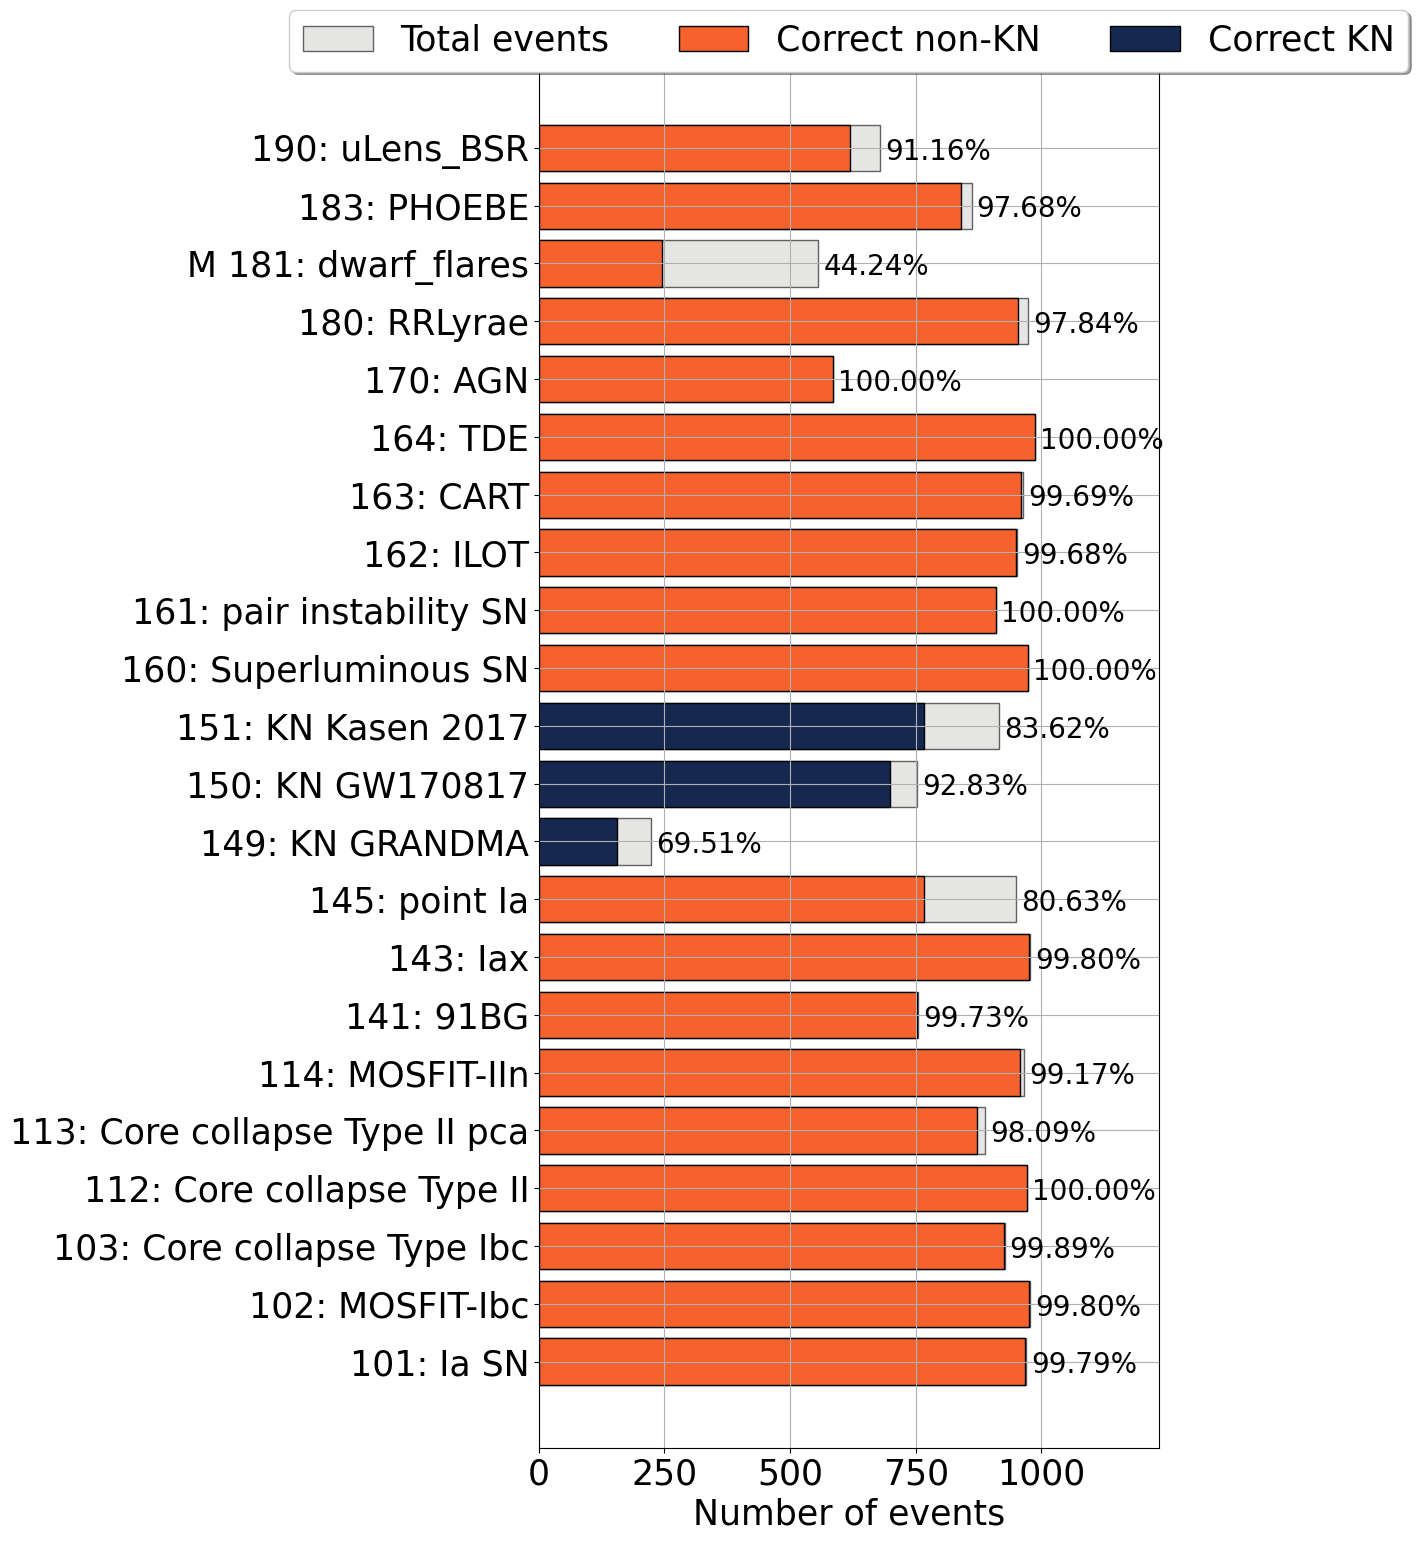

In [38]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,18))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151], save_fig_prefix=plot_path_prefix)
plt.show()

In [39]:
from kndetect.plot_lightcurve import plot_band_correlation
from kndetect.plot_lightcurve import plot_features_correlation

In [40]:
filtered

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,type,type_names,y_true,y_pred_score,y_score
0,0.634581,0.199713,-0.045995,4.704726,3813.011456,0.770813,0.241264,-0.041412,9.003170,5518.907806,1612,149,149: KN GRANDMA,True,0.666667,0.800000
1,1.689961,-0.488228,0.291873,4.044273,1215.978638,1.245018,-0.387239,-0.008178,8.407821,1900.364746,10871,162,162: ILOT,False,0.100000,0.033333
2,0.530729,0.322557,-0.059200,1.770705,764.863892,0.656105,0.215250,-0.061139,1.791454,805.522644,10872,150,150: KN GW170817,True,0.600000,0.433333
3,0.375809,0.246783,-0.667758,13.745609,2329.209717,0.164850,0.096115,0.144859,12.132693,1588.494263,11422,180,180: RRLyrae,False,0.200000,0.266667
4,-0.135169,0.104079,-0.062900,45.273972,20902.640625,0.082461,0.122986,0.234694,38.864068,11635.100586,13390,180,180: RRLyrae,False,0.200000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21283,0.871747,0.627985,0.575338,3.921973,1325.314697,1.181615,-0.166189,0.313255,1.544002,1154.043457,137049400,183,183: PHOEBE,False,0.133333,0.233333
21284,0.399185,0.000266,0.335164,1.667693,229.678802,0.239151,0.115590,-0.001880,2.751280,785.573853,137051059,181,M 181: dwarf_flares,False,0.500000,0.533333
21285,0.880921,-0.077851,-0.042582,1.082232,374.421295,1.151866,-0.151152,-0.000969,1.213220,341.236908,137054088,143,143: Iax,False,0.033333,0.033333
21286,0.306499,0.150967,-0.201772,1.877861,1000.960266,0.053889,0.019902,-0.011962,4.614387,3378.102295,137071432,181,M 181: dwarf_flares,False,0.800000,0.466667


In [41]:
kn_non_kn = []
for _, row in filtered.iterrows():
    if row["y_true"] == True:
        kn_non_kn.append("KN")
    else:
        kn_non_kn.append("non-KN")

filtered["kn_non_kn"] = kn_non_kn

/tmp/ipykernel_481/1082578403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["kn_non_kn"] = kn_non_kn


In [42]:
filtered

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,type,type_names,y_true,y_pred_score,y_score,kn_non_kn
0,0.634581,0.199713,-0.045995,4.704726,3813.011456,0.770813,0.241264,-0.041412,9.003170,5518.907806,1612,149,149: KN GRANDMA,True,0.666667,0.800000,KN
1,1.689961,-0.488228,0.291873,4.044273,1215.978638,1.245018,-0.387239,-0.008178,8.407821,1900.364746,10871,162,162: ILOT,False,0.100000,0.033333,non-KN
2,0.530729,0.322557,-0.059200,1.770705,764.863892,0.656105,0.215250,-0.061139,1.791454,805.522644,10872,150,150: KN GW170817,True,0.600000,0.433333,KN
3,0.375809,0.246783,-0.667758,13.745609,2329.209717,0.164850,0.096115,0.144859,12.132693,1588.494263,11422,180,180: RRLyrae,False,0.200000,0.266667,non-KN
4,-0.135169,0.104079,-0.062900,45.273972,20902.640625,0.082461,0.122986,0.234694,38.864068,11635.100586,13390,180,180: RRLyrae,False,0.200000,0.300000,non-KN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21283,0.871747,0.627985,0.575338,3.921973,1325.314697,1.181615,-0.166189,0.313255,1.544002,1154.043457,137049400,183,183: PHOEBE,False,0.133333,0.233333,non-KN
21284,0.399185,0.000266,0.335164,1.667693,229.678802,0.239151,0.115590,-0.001880,2.751280,785.573853,137051059,181,M 181: dwarf_flares,False,0.500000,0.533333,non-KN
21285,0.880921,-0.077851,-0.042582,1.082232,374.421295,1.151866,-0.151152,-0.000969,1.213220,341.236908,137054088,143,143: Iax,False,0.033333,0.033333,non-KN
21286,0.306499,0.150967,-0.201772,1.877861,1000.960266,0.053889,0.019902,-0.011962,4.614387,3378.102295,137071432,181,M 181: dwarf_flares,False,0.800000,0.466667,non-KN


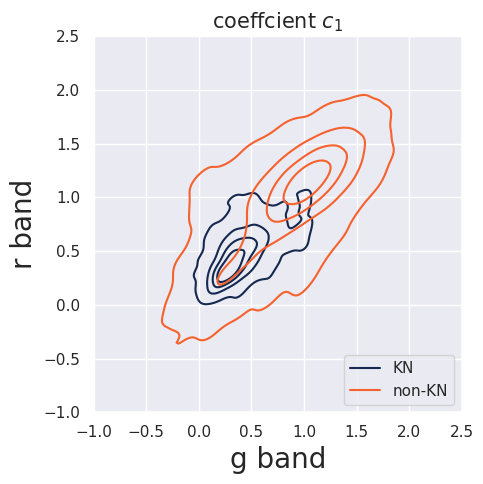

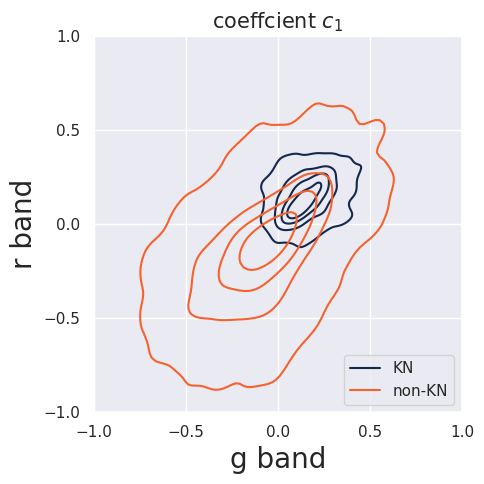

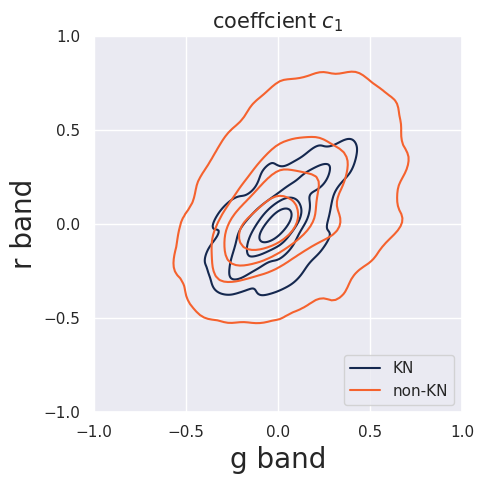

In [43]:
x_lims = [[-1, 2.5], [-1, 1], [-1, 1]]
y_lims = [[-1, 2.5], [-1, 1], [-1, 1]]
num_ticks = [5, 3, 3]
sns.set_style("darkgrid")
for i in range(3):
    fig=plt.figure(figsize=(5, 5))
    sns.kdeplot(
        data=filtered[filtered["y_true"]==True],
        x=f"coeff{i+1}_g",
        y=f"coeff{i+1}_r",
        color='#15284F',
        alpha=1,
        levels=5
    )

    sns.kdeplot(
        data=filtered[filtered["y_true"]==False],
        x=f"coeff{i+1}_g",
        y=f"coeff{i+1}_r",
        color='#F5622E',
        alpha=1,
        levels=5,
    )
    plt.xlim(x_lims[i])
    plt.ylim(y_lims[i])
    plt.plot([], [], c='#15284F', label='KN')
    plt.plot([], [], c='#F5622E', label='non-KN')
    plt.xticks(np.arange(x_lims[i][0], x_lims[i][1] + .5, step=0.5))
    plt.yticks(np.arange(y_lims[i][0], y_lims[i][1] + .5, step=0.5))
    plt.legend(loc='lower right')
    plt.xlabel("g band", fontsize=20)
    plt.ylabel("r band", fontsize=20)
    plt.title(r"coeffcient $c_1$", fontsize=15)
    plt.tight_layout()
    
    # plt.savefig(os.path.join("results", sub_directory, "band_correlation_c" + 0 + ".pdf"))
    plt.savefig(os.path.join("results", sub_directory, f"band_correlation_c{i}"))
    #plt.show()

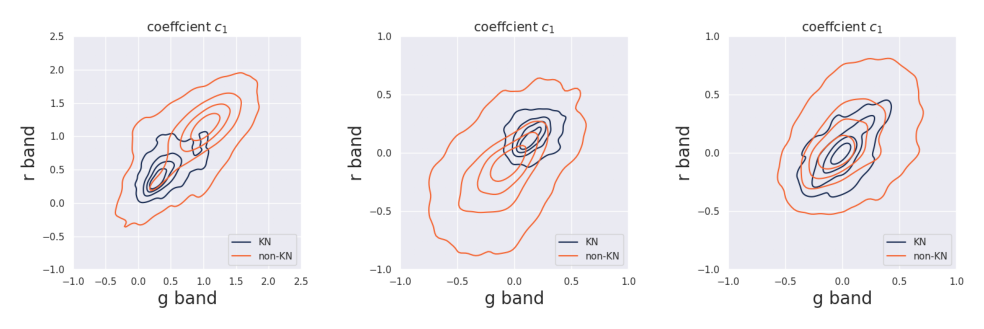

In [44]:
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 3, figsize=(10, 30))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
for i in range(3):
    axarr[i].imshow(mpimg.imread(os.path.join("results", sub_directory, f"band_correlation_c{i}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", sub_directory, "band_correlation_plot.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join("results", sub_directory, "band_correlation_plot"))

plt.show()

       g band     $c_1$     $c_2$     $c_3$
0          KN  0.634581  0.199713 -0.045995
1      non-KN  1.689961 -0.488228  0.291873
2          KN  0.530729  0.322557 -0.059200
3      non-KN  0.375809  0.246783 -0.667758
4      non-KN -0.135169  0.104079 -0.062900
...       ...       ...       ...       ...
21283  non-KN  0.871747  0.627985  0.575338
21284  non-KN  0.399185  0.000266  0.335164
21285  non-KN  0.880921 -0.077851 -0.042582
21286  non-KN  0.306499  0.150967 -0.201772
21287  non-KN  1.215101 -0.222415  0.023802

[18715 rows x 4 columns]


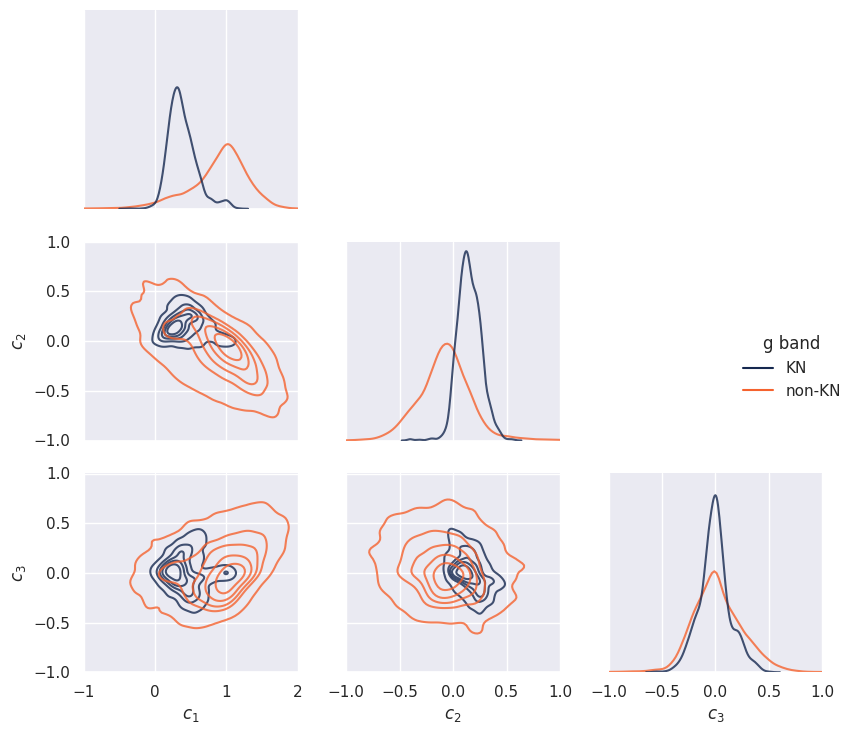

       r band     $c_1$     $c_2$     $c_3$
0          KN  0.770813  0.241264 -0.041412
1      non-KN  1.245018 -0.387239 -0.008178
2          KN  0.656105  0.215250 -0.061139
3      non-KN  0.164850  0.096115  0.144859
4      non-KN  0.082461  0.122986  0.234694
...       ...       ...       ...       ...
21283  non-KN  1.181615 -0.166189  0.313255
21284  non-KN  0.239151  0.115590 -0.001880
21285  non-KN  1.151866 -0.151152 -0.000969
21286  non-KN  0.053889  0.019902 -0.011962
21287  non-KN  1.055637 -0.320407 -0.106644

[18715 rows x 4 columns]


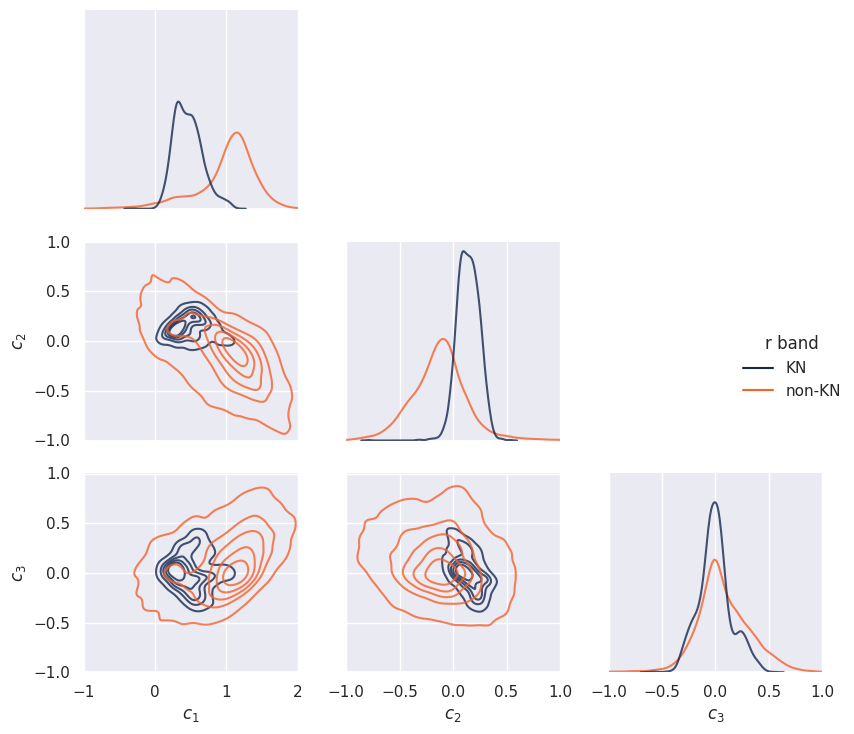

In [72]:
bands = ["g", "r"]
#clip = [[-1, -1, -1], [2, 1, 1]]
for band in bands:
    cols=["kn_non_kn"]
    for i in range(3):
        cols.append(f"coeff{i+1}_"+band)
    current_df = filtered[cols]
    
    rename_dict = {}
    for i in range(3):
        rename_dict[f"coeff{i+1}_"+band] = fr"$c_{i+1}$"
    current_df=current_df.rename(columns=rename_dict)
    current_df=current_df.rename(columns={"kn_non_kn": band + " band"})
    print(current_df)
    g = sns.PairGrid(data=current_df, hue=band + " band", corner=True)
    g.map_lower(sns.kdeplot, levels=6, palette=['#15284F', '#F5622E'], common_norm=False, alpha=.8)
    g.map_diag(sns.kdeplot, palette=['#15284F', '#F5622E'], common_norm=False, alpha=.8)
    g.add_legend()

    g.axes[0,0].set_xlim(-1,2)
    g.axes[1,1].set_xlim(-1,1)
    g.axes[2,2].set_xlim(-1,1)
    
    g.axes[0,0].set_ylim(-1,2)
    g.axes[1,1].set_ylim(-1,1)
    g.axes[2,2].set_ylim(-1,1)

    plt.tight_layout()
    plt.savefig(os.path.join("results", sub_directory, "features_correlation_"+band))
    plt.show()

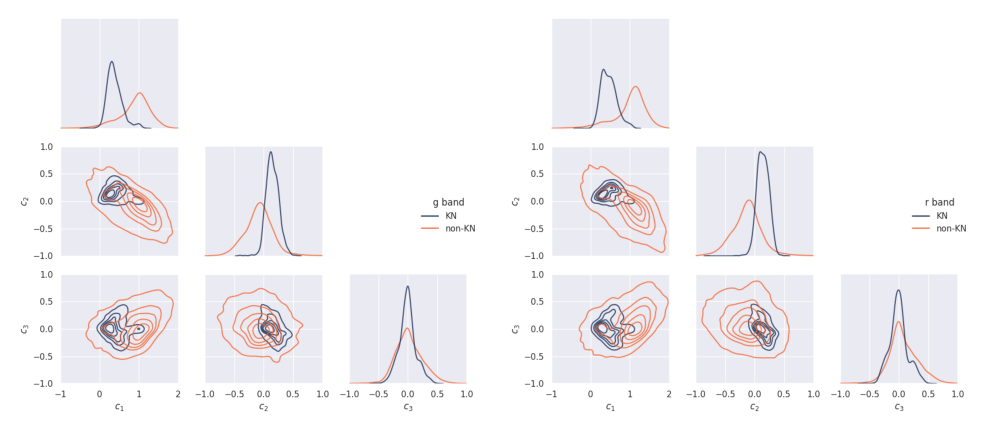

In [73]:
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 2, figsize=(10, 20))

axarr[0].imshow(mpimg.imread(os.path.join("results", sub_directory, "features_correlation_g.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", sub_directory, "features_correlation_r.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig(os.path.join("results", sub_directory, "features_correlation_plot.pdf"), format="pdf", bbox_inches="tight")
plt.savefig(os.path.join("results", sub_directory, "features_correlation_plot"))

plt.show()